# GIAI ĐOẠN 0 — Mount Drive + Auto-detect

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
DATA_ROOT = "/content/drive/MyDrive/ESC-50-master"


In [3]:
import os
META_CSV  = os.path.join(DATA_ROOT, "meta", "esc50.csv")
AUDIO_DIR = os.path.join(DATA_ROOT, "audio")

In [4]:
print("Exists meta?", os.path.exists(META_CSV))
print("Exists audio?", os.path.exists(AUDIO_DIR))

Exists meta? True
Exists audio? True


# GIAI ĐOẠN 1 — Setup & Data Integrity

Mục tiêu:
- Đọc ESC-50 từ Google Drive
- Chuẩn hoá pipeline split (theo fold hoặc random nhưng phải minh bạch)
- Sanity checks: số lớp, phân bố nhãn, độ dài audio, sample rate

Output của GĐ1:
- DataFrame metadata sạch
- danh sách (filepath, label_id) cho train/val/test


## 1.1 Load metadata ESC-50
ESC-50 có file `esc50.csv` chứa:
- filename
- category (tên lớp)
- fold (1..5)

Chúng ta ưu tiên split theo fold để báo cáo chặt chẽ.


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

df = pd.read_csv(META_CSV)
df["filepath"] = df["filename"].apply(lambda x: os.path.join(AUDIO_DIR, x))

missing = df.loc[~df["filepath"].apply(os.path.exists)]
print("Rows:", len(df))
print("Missing wav:", len(missing))
print("Unique classes:", df["category"].nunique())
print("Folds:", sorted(df["fold"].unique()))

if len(missing) > 0:
    print("Ví dụ file thiếu:")
    display(missing.head())


Rows: 2000
Missing wav: 0
Unique classes: 50
Folds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


## 1.2 Split strategy (khuyến nghị: theo fold)
- Cách "chuẩn ESC-50": chọn 1 fold làm test (vd fold=5), phần còn lại train/val.
- Lợi ích: dễ giải thích, tái lập, tránh tranh cãi.

Nếu bạn muốn random split: phải nói rõ seed + stratify.


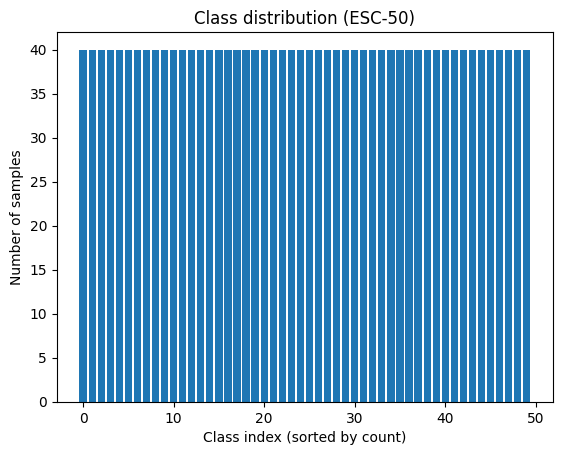

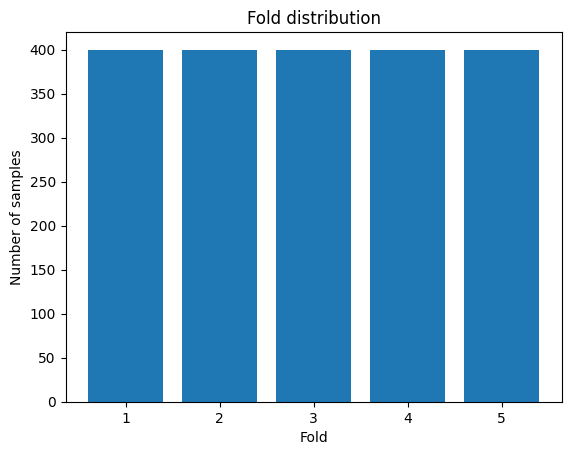

In [6]:
import matplotlib.pyplot as plt

class_counts = df["category"].value_counts().sort_values(ascending=False)

plt.figure()
plt.bar(range(len(class_counts)), class_counts.values)
plt.title("Class distribution (ESC-50)")
plt.xlabel("Class index (sorted by count)")
plt.ylabel("Number of samples")
plt.show()

fold_counts = df["fold"].value_counts().sort_index()
plt.figure()
plt.bar(fold_counts.index.astype(str), fold_counts.values)
plt.title("Fold distribution")
plt.xlabel("Fold")
plt.ylabel("Number of samples")
plt.show()


In [7]:
TEST_FOLD = 5

df_trainval = df[df["fold"] != TEST_FOLD].reset_index(drop=True)
df_test     = df[df["fold"] == TEST_FOLD].reset_index(drop=True)

le = LabelEncoder()
le.fit(df["category"].values)

df_trainval["y"] = le.transform(df_trainval["category"].values)
df_test["y"]     = le.transform(df_test["category"].values)

df_train, df_val = train_test_split(
    df_trainval,
    test_size=0.2,
    random_state=42,
    stratify=df_trainval["y"]
)

df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)

print("Train/Val/Test:", len(df_train), len(df_val), len(df_test))
print("Num classes:", len(le.classes_))

def dist(name, dfx):
    c = Counter(dfx["y"].values)
    print(f"{name}: unique={len(c)}, min={min(c.values())}, max={max(c.values())}")

dist("TRAIN", df_train)
dist("VAL", df_val)
dist("TEST", df_test)


Train/Val/Test: 1280 320 400
Num classes: 50
TRAIN: unique=50, min=25, max=26
VAL: unique=50, min=6, max=7
TEST: unique=50, min=8, max=8


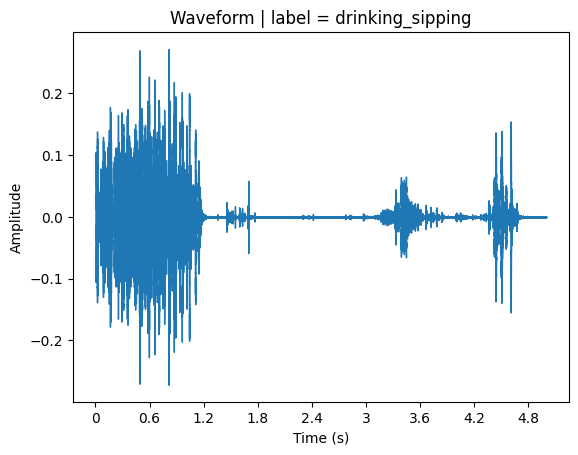

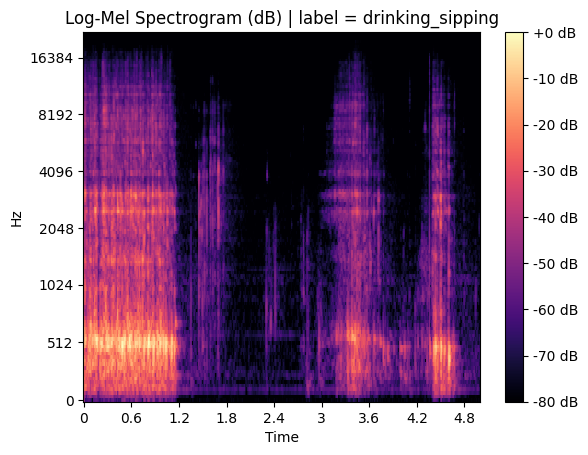

In [8]:
import numpy as np
import librosa
import librosa.display

SR = 44100
DURATION = 5.0
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

# lấy 1 sample ngẫu nhiên
row = df_train.sample(1, random_state=7).iloc[0]
path = row["filepath"]
label = row["category"]

y, sr = librosa.load(path, sr=SR, duration=DURATION)
y = librosa.util.fix_length(y, size=int(SR * DURATION))

# waveform
plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform | label = {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# log-mel
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
ref = np.max(mel) if np.max(mel) > 1e-6 else 1e-6
logmel = librosa.power_to_db(mel, ref=ref)

plt.figure()
librosa.display.specshow(logmel, sr=sr, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel")
plt.title(f"Log-Mel Spectrogram (dB) | label = {label}")
plt.colorbar(format="%+2.0f dB")
plt.show()


In [9]:
import os, numpy as np
import sklearn

# đường dẫn cache đúng theo notebook của bạn
CACHE_DIR = os.path.join(DATA_ROOT, "cache_features")
cache_path_3ch = os.path.join(CACHE_DIR, "logmel_delta_std_3ch_128mel.npz")

assert os.path.exists(cache_path_3ch), f"Không thấy cache: {cache_path_3ch}"

pack = np.load(cache_path_3ch, allow_pickle=True)

X_train = pack["X_train"]; y_train = pack["y_train"].astype(int)
X_val   = pack["X_val"];   y_val   = pack["y_val"].astype(int)
X_test  = pack["X_test"];  y_test  = pack["y_test"].astype(int)

train_mean = pack["mean"]; train_std = pack["std"]
classes = list(pack["classes"])

print("✅ Loaded cache:", cache_path_3ch)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# tái tạo LabelEncoder để dùng inverse_transform như notebook đang dùng
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(classes)
print("✅ Rebuilt LabelEncoder with", len(le.classes_), "classes")


✅ Loaded cache: /content/drive/MyDrive/ESC-50-master/cache_features/logmel_delta_std_3ch_128mel.npz
Shapes: (1280, 128, 431, 3) (320, 128, 431, 3) (400, 128, 431, 3)
✅ Rebuilt LabelEncoder with 50 classes


# Giai đoạn 2



Input:
- df_train/df_val/df_test với cột: filepath, y (label index)

Process:
- Load waveform (SR=44100, length=5s)
- Compute Mel-spectrogram -> log(dB)
- Chuẩn hoá ổn định (standardize theo dataset train)

Output:
- X_train, y_train
- X_val, y_val
- X_test, y_test
- mean/std (để chuẩn hoá nhất quán)
- Các sanity check + trực quan hoá (trước/sau chuẩn hoá)


In [ ]:
#Cell 2.1 — Config + helper (3-channel: logmel + delta + delta2)
import librosa
import numpy as np

EPS = 1e-6
SAMPLES = int(SR * DURATION)

def load_fixed_audio(path, sr=SR, samples=SAMPLES):
    y, _ = librosa.load(path, sr=sr, mono=True, duration=DURATION)
    y = librosa.util.fix_length(y, size=samples)
    return y

def logmel_from_wave(y, sr=SR):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=2.0
    )
    ref = np.max(mel)
    if ref < EPS:
        T = mel.shape[1]
        return np.zeros((N_MELS, T), dtype=np.float32)

    logmel = librosa.power_to_db(mel, ref=ref)
    logmel = np.nan_to_num(logmel, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return logmel

def extract_logmel_3ch(audio_path):
    y = load_fixed_audio(audio_path)
    logmel = logmel_from_wave(y)                 # (128, T)
    d1 = librosa.feature.delta(logmel)           # (128, T)
    d2 = librosa.feature.delta(logmel, order=2)  # (128, T)

    feat = np.stack([logmel, d1, d2], axis=-1).astype(np.float32)  # (128, T, 3)
    feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)
    return feat


In [ ]:
# Cell 2.2 — Extract (3-channel) + sanity
from tqdm import tqdm
import numpy as np

def extract_split(df_split, desc="split"):
    X = []
    y = df_split["y"].values.astype(np.int64)

    bad = 0
    for p in tqdm(df_split["filepath"].values, desc=f"Extract {desc}"):
        feat = extract_logmel_3ch(p)  # (128, T, 3)
        if not np.isfinite(feat).all():
            bad += 1
            feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)
        X.append(feat)

    X = np.stack(X, axis=0).astype(np.float32)  # (N, 128, T, 3)
    print(f"[{desc}] X shape:", X.shape, "| y shape:", y.shape, "| bad fixed:", bad)
    print(f"[{desc}] finite?", np.isfinite(X).all(), "| min/max:", float(X.min()), float(X.max()))
    return X, y

X_train_raw, y_train = extract_split(df_train, "train")
X_val_raw,   y_val   = extract_split(df_val,   "val")
X_test_raw,  y_test  = extract_split(df_test,  "test")

print("Label range:", y_train.min(), y_train.max(), "| num_classes:", len(le.classes_))


Extract train: 100%|██████████| 1280/1280 [17:05<00:00,  1.25it/s]


[train] X shape: (1280, 128, 431, 3) | y shape: (1280,) | bad fixed: 0
[train] finite? True | min/max: -80.0 13.263710021972656


Extract val: 100%|██████████| 320/320 [04:16<00:00,  1.25it/s]


[val] X shape: (320, 128, 431, 3) | y shape: (320,) | bad fixed: 0
[val] finite? True | min/max: -80.0 13.228540420532227


Extract test: 100%|██████████| 400/400 [05:17<00:00,  1.26it/s]


[test] X shape: (400, 128, 431, 3) | y shape: (400,) | bad fixed: 0
[test] finite? True | min/max: -80.0 13.175970077514648
Label range: 0 49 | num_classes: 50


## Chuẩn hoá (Standardization) theo tập train

Vì log-mel dB có thang đo tương đối, ta chuẩn hoá:
- mean/std tính trên toàn bộ train
- áp dụng cùng mean/std cho val/test

Lợi ích:
- ổn định training (giảm nguy cơ collapse)
- dễ giải thích trước thầy: "chuẩn hoá thống kê theo train để tránh leakage"


In [ ]:
#Cell 2.4 — Standardize per-channel using TRAIN stats
import numpy as np

train_mean = X_train_raw.mean(axis=(0,1,2), keepdims=True)          # (1,1,1,3)
train_std  = X_train_raw.std(axis=(0,1,2), keepdims=True) + 1e-6    # (1,1,1,3)

def standardize_ch(X, mean, std):
    Xn = (X - mean) / std
    Xn = np.nan_to_num(Xn, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return Xn

X_train = standardize_ch(X_train_raw, train_mean, train_std)
X_val   = standardize_ch(X_val_raw,   train_mean, train_std)
X_test  = standardize_ch(X_test_raw,  train_mean, train_std)

print("Standardized shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Train per-channel mean ~", X_train.mean(axis=(0,1,2)))
print("Train per-channel std  ~", X_train.std(axis=(0,1,2)))


Standardized shapes: (1280, 128, 431, 3) (320, 128, 431, 3) (400, 128, 431, 3)
Train per-channel mean ~ [-4.75174010e-01 -4.95453132e-05  1.18584385e-05]
Train per-channel std  ~ [0.6893757 1.0021478 1.0019886]


## Cache dữ liệu ra file .npz
- Lưu X/y + mean/std + label mapping
- Đảm bảo chạy lại không thay đổi kết quả


In [ ]:
#Cell 2.7 — Save cache (3ch)
import os, numpy as np

CACHE_DIR = os.path.join(DATA_ROOT, "cache_features")
os.makedirs(CACHE_DIR, exist_ok=True)

cache_path_3ch = os.path.join(CACHE_DIR, "logmel_delta_std_3ch_128mel.npz")

np.savez_compressed(
    cache_path_3ch,
    X_train=X_train, y_train=y_train,
    X_val=X_val,     y_val=y_val,
    X_test=X_test,   y_test=y_test,
    mean=train_mean, std=train_std,
    classes=np.array(le.classes_, dtype=object)
)

print("Saved 3ch cache:", cache_path_3ch)
print("Cache shapes:", X_train.shape, X_val.shape, X_test.shape)


Saved 3ch cache: /content/drive/MyDrive/ESC-50-master/cache_features/logmel_delta_std_3ch_128mel.npz
Cache shapes: (1280, 128, 431, 3) (320, 128, 431, 3) (400, 128, 431, 3)


## Trực quan hoá: Log-Mel trước và sau chuẩn hoá

Mục tiêu:
- cho thấy biểu diễn thời gian–tần số rõ ràng
- chứng minh pipeline có chuẩn hoá để training ổn định


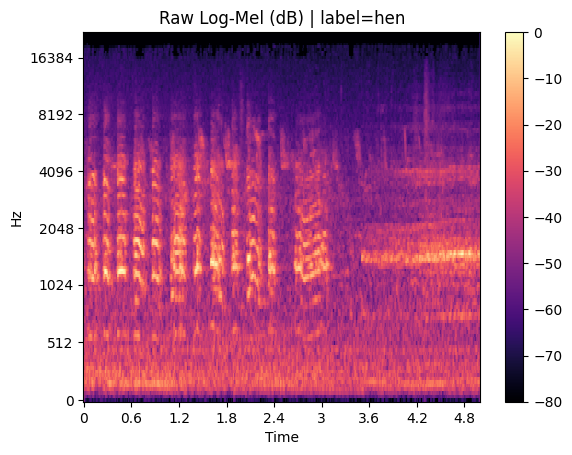

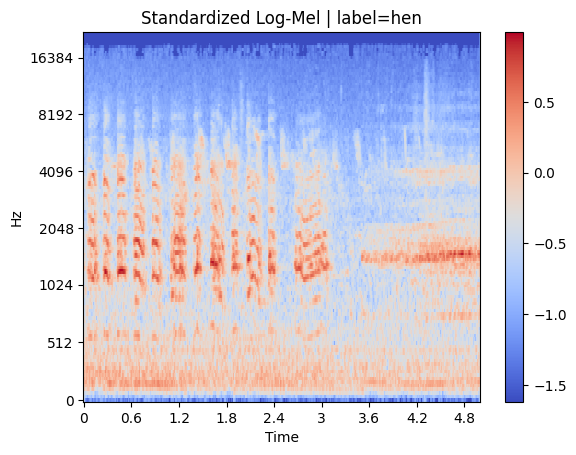

In [ ]:
#Cell 2.9 — Code: Plot 1 sample raw vs standardized
import matplotlib.pyplot as plt
import librosa.display

idx = 0
label_name = le.inverse_transform([y_train[idx]])[0]

raw = X_train_raw[idx]           # (128, T, 3)
std = X_train[idx, ..., 0]       # (128, T)

plt.figure()
librosa.display.specshow(raw[..., 0], x_axis="time", y_axis="mel", hop_length=HOP_LENGTH, sr=SR)
plt.title(f"Raw Log-Mel (dB) | label={label_name}")
plt.colorbar()
plt.show()

plt.figure()
librosa.display.specshow(std, x_axis="time", y_axis="mel", hop_length=HOP_LENGTH, sr=SR)
plt.title(f"Standardized Log-Mel | label={label_name}")
plt.colorbar()
plt.show()


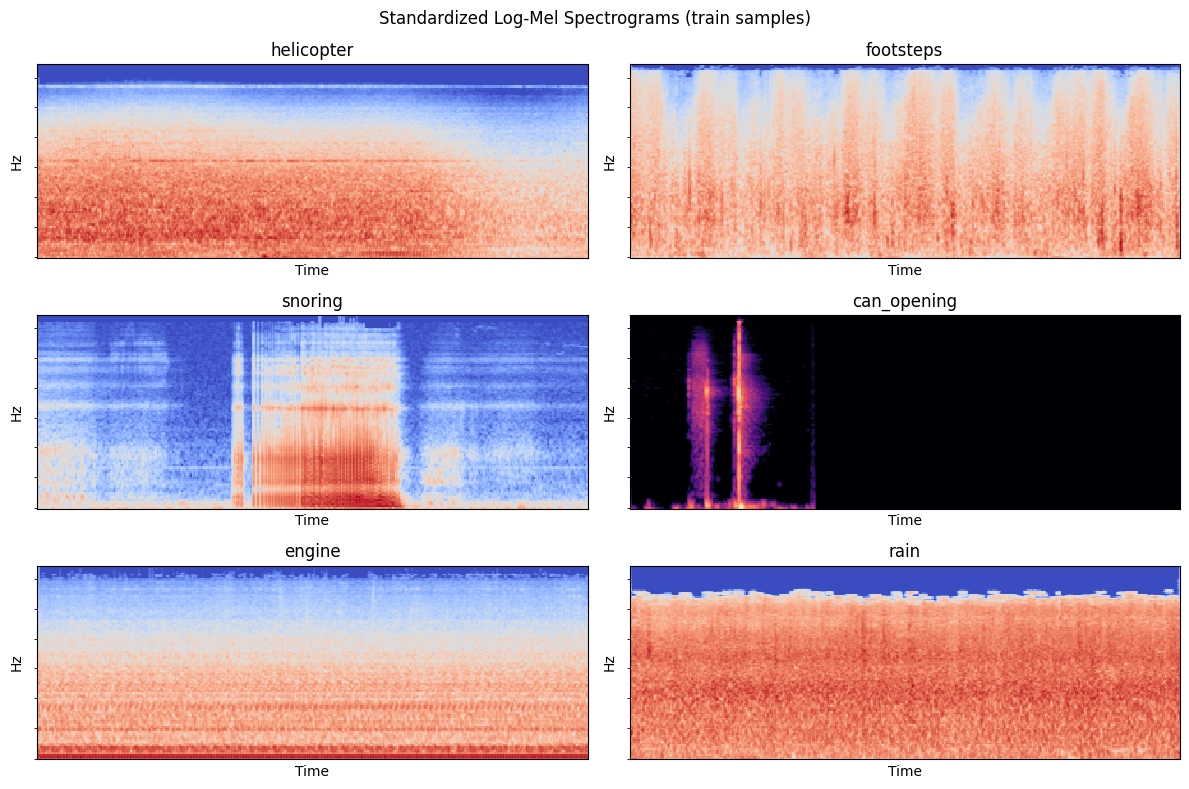

In [ ]:
#Cell 2.10 — Code: Plot 6 samples standardized
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

sel = np.random.RandomState(42).choice(len(X_train), size=6, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(sel):
    ax = plt.subplot(3, 2, i+1)
    spec = X_train[idx, ..., 0]
    lab = le.inverse_transform([y_train[idx]])[0]
    librosa.display.specshow(spec, x_axis="time", y_axis="mel", hop_length=HOP_LENGTH, sr=SR)
    ax.set_title(lab)
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle("Standardized Log-Mel Spectrograms (train samples)", y=0.98)
plt.tight_layout()
plt.show()


In [ ]:
#Cell 2.11 — kiểm tra label mapping + vài dòng đối chiếu
# in 10 dòng để chắc label không lệch
for i in range(10):
    r = df_train.iloc[i]
    print(i, os.path.basename(r["filepath"]), "| category:", r["category"], "| y:", r["y"], "| decoded:", le.inverse_transform([r["y"]])[0])


0 1-31251-B-6.wav | category: hen | y: 29 | decoded: hen
1 3-151081-B-20.wav | category: crying_baby | y: 17 | decoded: crying_baby
2 1-60460-A-36.wav | category: vacuum_cleaner | y: 46 | decoded: vacuum_cleaner
3 1-17150-A-12.wav | category: crackling_fire | y: 14 | decoded: crackling_fire
4 1-50688-A-17.wav | category: pouring_water | y: 35 | decoded: pouring_water
5 4-188293-A-15.wav | category: water_drops | y: 48 | decoded: water_drops
6 3-128160-A-44.wav | category: engine | y: 22 | decoded: engine
7 4-172377-A-17.wav | category: pouring_water | y: 35 | decoded: pouring_water
8 1-49409-B-8.wav | category: sheep | y: 39 | decoded: sheep
9 2-117617-A-48.wav | category: fireworks | y: 23 | decoded: fireworks


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(1280, 128, 431, 3) (320, 128, 431, 3) (400, 128, 431, 3)


In [ ]:
print("classes:", len(le.classes_), "train y unique:", len(np.unique(y_train)))

classes: 50 train y unique: 50


# GIAI ĐOẠN 3 — Huấn luyện CNN với SpecAugment (TF/Keras)

Input:
- X_train, y_train, X_val, y_val (đã standardize, có channel dim)

Process:
1) Build tf.data pipeline:
   - shuffle + batch + prefetch
   - SpecAugment chỉ áp dụng cho train (time mask + freq mask)
2) Build CNN (nhẹ nhưng đủ mạnh cho ESC-50)
3) Train với callbacks:
   - EarlyStopping
   - ReduceLROnPlateau
   - ModelCheckpoint

Output:
- best_model.keras
- history (loss/acc)


In [ ]:
#Cell 3.1 — Code: Seed + tf setup
import tensorflow as tf
import numpy as np
import os

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("TF version:", tf.__version__)


TF version: 2.19.0


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Cell 3.2 — SpecAugment (3ch, nhẹ hơn)
import tensorflow as tf

@tf.function
def spec_augment(x, y, freq_mask_param=12, time_mask_param=20, num_freq_masks=1, num_time_masks=1):
    # x: (H,W,C) = (128,431,3)
    H = tf.shape(x)[0]
    W = tf.shape(x)[1]
    C = tf.shape(x)[2]

    # Frequency Masking
    for _ in tf.range(num_freq_masks):
        f  = tf.random.uniform([], 0, freq_mask_param + 1, dtype=tf.int32)
        f0 = tf.random.uniform([], 0, tf.maximum(H - f, 1), dtype=tf.int32)

        # Create a frequency mask
        freq_mask = tf.concat([
            tf.ones([f0, W, C], dtype=x.dtype),
            tf.zeros([f, W, C], dtype=x.dtype),
            tf.ones([H - f0 - f, W, C], dtype=x.dtype)
        ], axis=0)
        x *= freq_mask

    # Time Masking
    for _ in tf.range(num_time_masks):
        t  = tf.random.uniform([], 0, time_mask_param + 1, dtype=tf.int32)
        t0 = tf.random.uniform([], 0, tf.maximum(W - t, 1), dtype=tf.int32)

        # Create a time mask
        time_mask = tf.concat([
            tf.ones([H, t0, C], dtype=x.dtype),
            tf.zeros([H, t, C], dtype=x.dtype),
            tf.ones([H, W - t0 - t, C], dtype=x.dtype)
        ], axis=1)
        x *= time_mask

    return x, y


In [ ]:
#Cell 3.3 — tf.data pipelines (3ch)
import tensorflow as tf
import numpy as np

BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train), seed=42, reshuffle_each_iteration=True)
train_ds = train_ds.map(spec_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print("train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("val batches  :", tf.data.experimental.cardinality(val_ds).numpy())

# sanity: batch shape phải là (B,128,431,3)
for xb, yb in train_ds.take(1):
    print("BATCH x shape:", xb.shape, "BATCH y shape:", yb.shape)


train batches: 40
val batches  : 10
BATCH x shape: (32, 128, 431, 3) BATCH y shape: (32,)


## Kiến trúc CNN (gọn, chặt, dễ trình bày)

Ý tưởng:
- Conv2D học "mẫu hình cục bộ" trên ảnh log-mel
- MaxPool giảm kích thước, giữ đặc trưng nổi bật
- BatchNorm ổn định gradient
- Dropout giảm overfit
- GlobalAveragePooling giúp mô hình "nhìn tổng quan" và hỗ trợ explainability (Grad-CAM)


In [ ]:
#Cell 3.5 — Code: Define model
from tensorflow.keras import layers, models

NUM_CLASSES = len(le.classes_)

def build_cnn(input_shape=(128, 431, 1), num_classes=NUM_CLASSES):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding="same", use_bias=False)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,2))(x)   # (64, ~215)

    x = layers.Conv2D(64, (3,3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,2))(x)   # (32, ~107)

    x = layers.Conv2D(128, (3,3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D((2,2))(x)   # (16, ~53)

    x = layers.Conv2D(256, (3,3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Quan trọng cho Grad-CAM: giữ feature map trước GAP
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inp, out)

model = build_cnn(input_shape=X_train.shape[1:])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 431, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 431, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 431, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128, 431, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 215, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 215, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 215, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 107, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 107, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 107, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 107, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 53, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 53, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 16, 53, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,706 (1.54 MB)

 Trainable params: 401,746 (1.53 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
#Cell 3.6 — Compile (AdamW + CosineDecay + label smoothing)
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import LearningRateScheduler

steps_per_epoch = int(np.ceil(len(X_train)/BATCH_SIZE))
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=steps_per_epoch * 40,
    alpha=1e-2
)

# KhởI TẠO OPTIMIZER VỚ KÈM INITIAL LEARNING RATE (FLOAT) thay vì SCHEDULE OBJECT
optimizer = optimizers.AdamW(learning_rate=lr_schedule.initial_learning_rate, weight_decay=1e-4)


model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(),
    metrics=[
        SparseCategoricalAccuracy(name="acc"),
        SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)


In [ ]:
# Cell 3.7 — Callbacks (monitor val_acc để tối ưu accuracy)
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

OUT_DIR = os.path.join(DATA_ROOT, "models")
os.makedirs(OUT_DIR, exist_ok=True)

ckpt_path_3ch = os.path.join(OUT_DIR, "cnn_logmel_3ch_best_acc.keras")

checkpoint = ModelCheckpoint(
    ckpt_path_3ch,
    monitor="val_acc",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_acc",
    mode="max",
    patience=12,
    min_delta=0.002,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, early_stop]
print("Checkpoint (best val_acc):", ckpt_path_3ch)


Checkpoint (best val_acc): /content/drive/MyDrive/ESC-50-master/models/cnn_logmel_3ch_best_acc.keras


In [ ]:
#Cell 3.8 — Train
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.7588 - loss: 1.0124 - top5_acc: 0.9645
Epoch 1: val_acc improved from -inf to 0.37500, saving model to /content/drive/MyDrive/ESC-50-master/models/cnn_logmel_3ch_best_acc.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - acc: 0.7578 - loss: 1.0138 - top5_acc: 0.9643 - val_acc: 0.3750 - val_loss: 2.7590 - val_top5_acc: 0.7094
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - acc: 0.7636 - loss: 0.9259 - top5_acc: 0.9777
Epoch 2: val_acc improved from 0.37500 to 0.44375, saving model to /content/drive/MyDrive/ESC-50-master/models/cnn_logmel_3ch_best_acc.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - acc: 0.7633 - loss: 0.9267 - top5_acc: 0.9774 - val_acc: 0.4437 - val_loss: 2.2239 - val_top5_acc: 0.8062
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.8051 - loss: 0.8385 - top5_acc: 0.9873
Epoch 3: val_acc improved from 0.44375 to 0.59375, saving model to /content/drive/MyDrive/ESC-50-master/models/cnn_logmel_3ch_b

In [ ]:
best_epoch = int(np.argmin(history.history["val_loss"])) + 1
best_val_loss = float(np.min(history.history["val_loss"]))
best_val_acc = float(history.history["val_acc"][best_epoch-1])

print("Best epoch:", best_epoch)
print("Best val_loss:", best_val_loss)
print("Val acc at best epoch:", best_val_acc)


Best epoch: 46
Best val_loss: 0.7989259958267212
Val acc at best epoch: 0.784375011920929


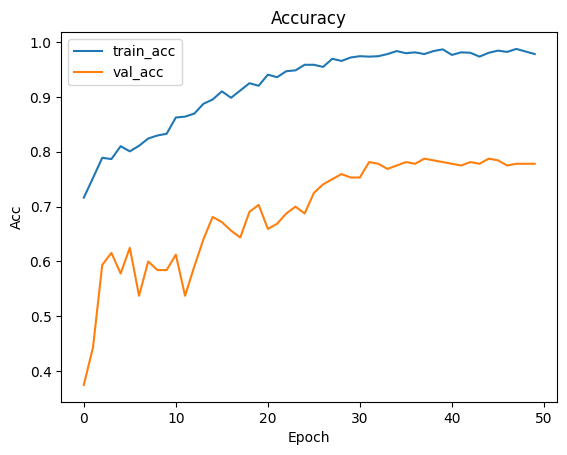

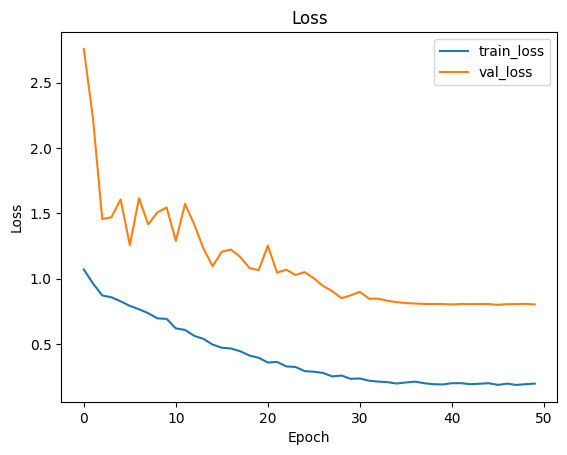

In [ ]:
#Cell 3.9 — Code: Plot learning curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["acc"], label="train_acc")
plt.plot(history.history["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
#Cell 3.10 — Sanity check “predict 1 lớp” ngay sau training
# Lấy 1 batch val, xem model đoán phân bố có đa dạng không
for xb, yb in val_ds.take(1):
    probs = model.predict(xb, verbose=0)
    pred = np.argmax(probs, axis=1)

print("Unique preds in 1 val batch:", len(np.unique(pred)))
print("Some preds:", pred[:20])
print("Some true :", yb.numpy()[:20])


Unique preds in 1 val batch: 25
Some preds: [16 31 13  5 18  5  4  8 17 37 14 34 41 26 44 38  4 45 37 30]
Some true : [ 1 31 13  5 25 16  4  8 17 29 14 34 41 26 44 38 40 45 37 32]


In [ ]:
best_val_acc = max(history.history["val_acc"])
best_top5 = max(history.history["val_top5_acc"])
best_epoch = int(np.argmax(history.history["val_acc"])) + 1
print(best_val_acc, best_top5, best_epoch)


0.7875000238418579 0.971875011920929 38


In [ ]:
import os
print("Checkpoint exists?", os.path.exists(ckpt_path), ckpt_path)
if os.path.exists(ckpt_path):
    print("Size (MB):", os.path.getsize(ckpt_path)/1024/1024)


Checkpoint exists? True /content/drive/MyDrive/ESC-50-master/models/cnn_logmel_best.keras
Size (MB): 4.679355621337891


In [ ]:
import tensorflow as tf
best_model = tf.keras.models.load_model(ckpt_path)
print("Loaded best model from:", ckpt_path)


Loaded best model from: /content/drive/MyDrive/ESC-50-master/models/cnn_logmel_best.keras


# GIAI ĐOẠN 3.5 — Đánh giá mô hình trên TEST

Mục tiêu:
- Báo cáo Accuracy / Top-5 Accuracy trên TEST
- In classification report (precision/recall/F1)
- Vẽ confusion matrix (chuẩn để đưa vào báo cáo)
- Lưu kết quả dự đoán để phân tích lỗi


In [10]:
#Cell 3.5.0:
import os
import numpy as np
import tensorflow as tf

# Ưu tiên checkpoint best theo val_acc (tên mình đã hướng dẫn ở Cell 3.7)
ckpt_best_acc = os.path.join(DATA_ROOT, "models", "cnn_logmel_3ch_best_acc.keras")

if os.path.exists(ckpt_best_acc):
    model_eval = tf.keras.models.load_model(ckpt_best_acc)
    print("✅ Loaded checkpoint:", ckpt_best_acc)
else:
    model_eval = model  # fallback
    print("⚠️ Checkpoint not found, using current `model` in RAM.")


✅ Loaded checkpoint: /content/drive/MyDrive/ESC-50-master/models/cnn_logmel_3ch_best_acc.keras


In [11]:
#Cell 3.5.1 — Code: chuẩn bị test dataset
import tensorflow as tf

BATCH_SIZE = 32

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Test batches: 13


In [12]:
#Cell 3.5.2 — Code: test metrics (acc/top5)
test_metrics = model_eval.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(model_eval.metrics_names, test_metrics)))


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - acc: 0.7064 - loss: 1.1807 - top5_acc: 0.9032
Test metrics: {'loss': 1.061793565750122, 'compile_metrics': 0.7200000286102295}


In [13]:
#Cell 3.5.3 — Code: lấy dự đoán + sanity (có collapse không)
probs = model_eval.predict(test_ds, verbose=0)
y_pred = np.argmax(probs, axis=1)

print("Unique predicted classes:", len(np.unique(y_pred)))
print("Unique true classes     :", len(np.unique(y_test)))


Unique predicted classes: 50
Unique true classes     : 50


In [14]:
#Cell 3.5.4 — Code: classification report (macro-F1)
from sklearn.metrics import classification_report, accuracy_score

print("Test accuracy:", accuracy_score(y_test, y_pred))

target_names = list(le.classes_)
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))


Test accuracy: 0.72
                  precision    recall  f1-score   support

        airplane     0.6667    0.5000    0.5714         8
       breathing     1.0000    0.3750    0.5455         8
  brushing_teeth     0.8571    0.7500    0.8000         8
     can_opening     0.6000    0.3750    0.4615         8
        car_horn     0.6667    1.0000    0.8000         8
             cat     0.8333    0.6250    0.7143         8
        chainsaw     0.8571    0.7500    0.8000         8
  chirping_birds     0.8750    0.8750    0.8750         8
    church_bells     1.0000    1.0000    1.0000         8
        clapping     0.6667    0.5000    0.5714         8
     clock_alarm     1.0000    1.0000    1.0000         8
      clock_tick     0.4444    0.5000    0.4706         8
        coughing     0.5000    0.8750    0.6364         8
             cow     0.6364    0.8750    0.7368         8
  crackling_fire     0.6667    0.7500    0.7059         8
        crickets     0.7500    0.7500    0.7500    

In [15]:
import os, json, time
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

EXPORT_DIR = os.path.join(DATA_ROOT, "models", "eval_artifacts")
os.makedirs(EXPORT_DIR, exist_ok=True)

TAG = "cnn_logmel_3ch_best_acc_test"  # đổi tag nếu bạn muốn (vd: specaug_v2)

# 1) classification report -> dataframe
target_names = list(le.classes_)
rep = classification_report(
    y_test, y_pred,
    target_names=target_names,
    output_dict=True,
    digits=4,
    zero_division=0
)
df_rep = pd.DataFrame(rep).T  # rows: each class + accuracy + macro avg + weighted avg

csv_path = os.path.join(EXPORT_DIR, f"{TAG}_cls_report.csv")
tex_path = os.path.join(EXPORT_DIR, f"{TAG}_cls_report.tex")
df_rep.to_csv(csv_path, index=True)
df_rep[["precision","recall","f1-score","support"]].to_latex(tex_path, float_format="%.4f")

# 2) confusion matrix -> .npy
cm = confusion_matrix(y_test, y_pred)
cm_path = os.path.join(EXPORT_DIR, f"{TAG}_cm.npy")
np.save(cm_path, cm)

# 3) cache dự đoán (để khỏi predict lại)
npz_path = os.path.join(EXPORT_DIR, f"{TAG}_preds.npz")
np.savez_compressed(npz_path, y_true=y_test, y_pred=y_pred, probs=probs, classes=np.array(target_names, dtype=object))

# 4) meta
meta = {
    "tag": TAG,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "n_samples": int(len(y_test)),
    "n_classes": int(len(target_names))
}
meta_path = os.path.join(EXPORT_DIR, f"{TAG}_meta.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Saved:")
print("-", csv_path)
print("-", tex_path, "(dán thẳng vào LaTeX)")
print("-", cm_path)
print("-", npz_path)
print("-", meta_path)

# Quick show (macro/weighted để trả lời thầy cực nhanh)
display(df_rep.loc[["accuracy", "macro avg", "weighted avg"], ["precision","recall","f1-score","support"]])


✅ Saved:
- /content/drive/MyDrive/ESC-50-master/models/eval_artifacts/cnn_logmel_3ch_best_acc_test_cls_report.csv
- /content/drive/MyDrive/ESC-50-master/models/eval_artifacts/cnn_logmel_3ch_best_acc_test_cls_report.tex (dán thẳng vào LaTeX)
- /content/drive/MyDrive/ESC-50-master/models/eval_artifacts/cnn_logmel_3ch_best_acc_test_cm.npy
- /content/drive/MyDrive/ESC-50-master/models/eval_artifacts/cnn_logmel_3ch_best_acc_test_preds.npz
- /content/drive/MyDrive/ESC-50-master/models/eval_artifacts/cnn_logmel_3ch_best_acc_test_meta.json


,precision,recall,f1-score,support
accuracy,0.720000,0.72,0.72000,0.72
macro avg,0.738525,0.72,0.70733,400.00
weighted avg,0.738525,0.72,0.70733,400.00


In [16]:
import os, numpy as np, pandas as pd

EXPORT_DIR = os.path.join(DATA_ROOT, "models", "eval_artifacts")
TAG = "cnn_logmel_3ch_best_acc_test"

df_rep = pd.read_csv(os.path.join(EXPORT_DIR, f"{TAG}_cls_report.csv"), index_col=0)
cm = np.load(os.path.join(EXPORT_DIR, f"{TAG}_cm.npy"))
pack = np.load(os.path.join(EXPORT_DIR, f"{TAG}_preds.npz"), allow_pickle=True)

print("Loaded report + cm + preds")
display(df_rep.loc[["accuracy", "macro avg", "weighted avg"], ["precision","recall","f1-score","support"]])
print("CM shape:", cm.shape)


Loaded report + cm + preds


,precision,recall,f1-score,support
accuracy,0.720000,0.72,0.72000,0.72
macro avg,0.738525,0.72,0.70733,400.00
weighted avg,0.738525,0.72,0.70733,400.00


CM shape: (50, 50)


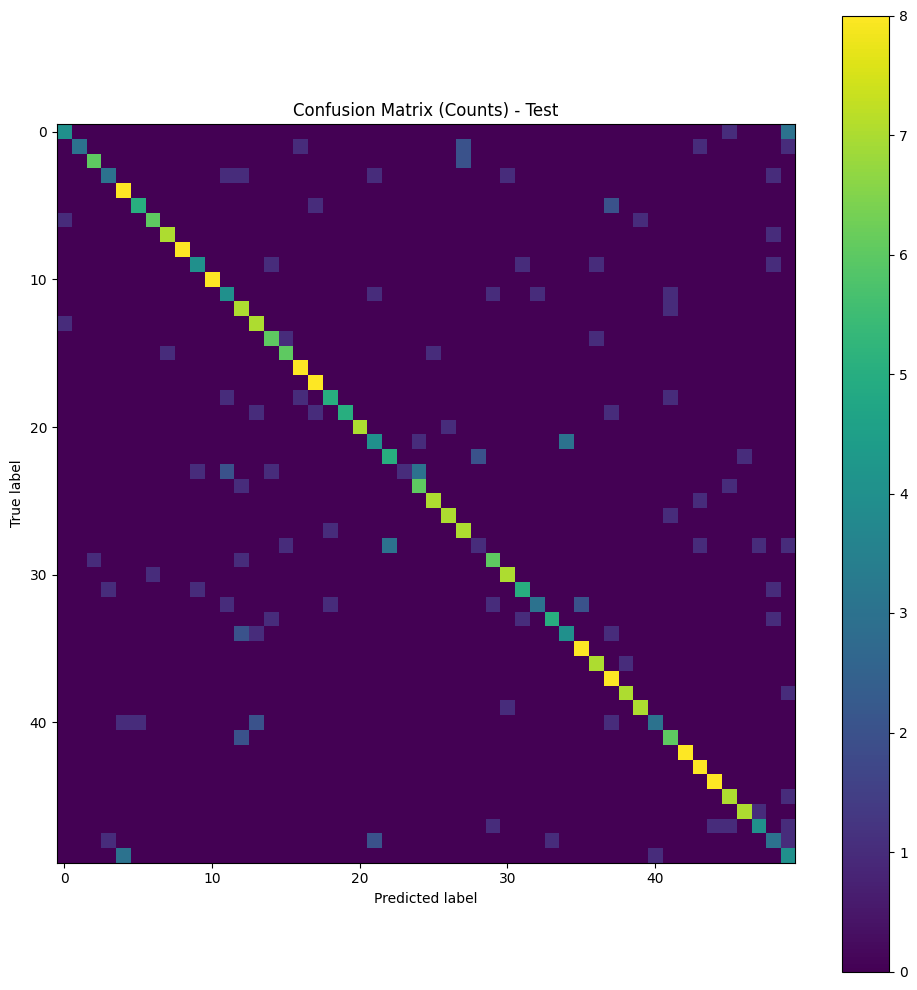

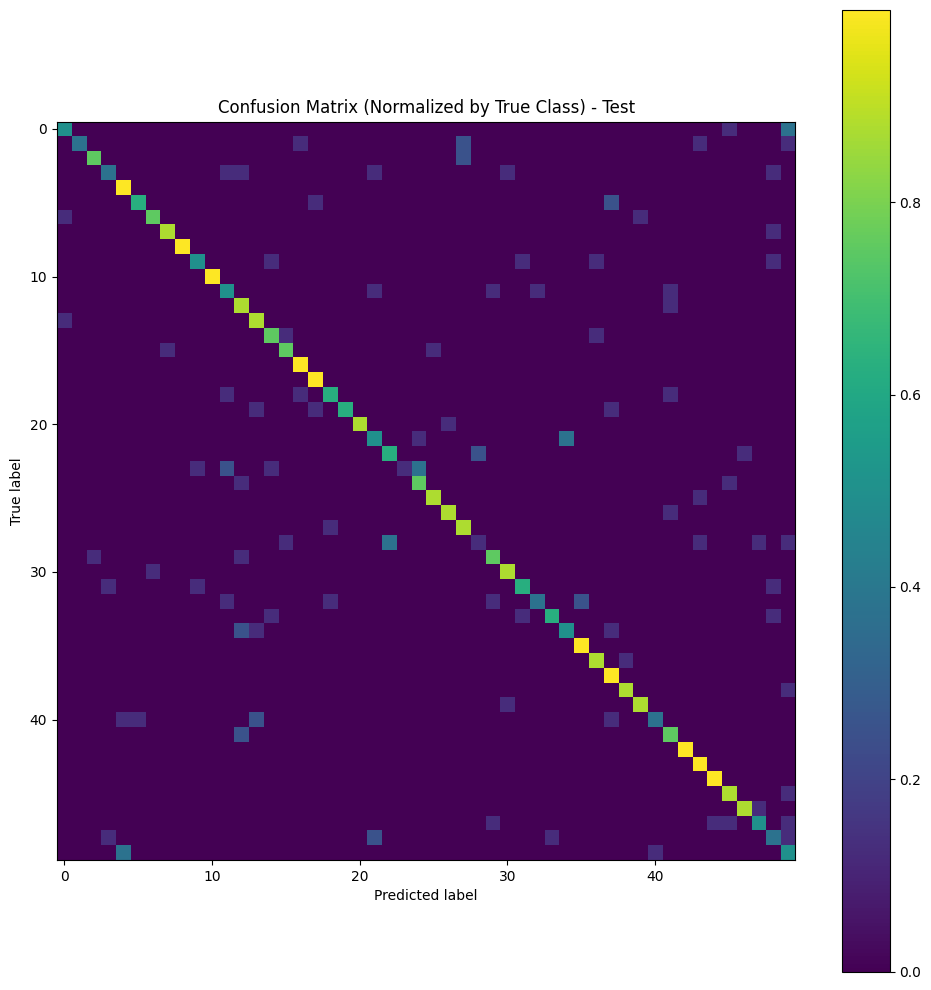

In [ ]:
#Cell 3.5.5 — Code: Confusion matrix:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Raw counts
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Counts) - Test")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()

# Normalized by true class (row-wise)
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-8)

plt.figure(figsize=(10, 10))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (Normalized by True Class) - Test")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
#Cell 3.5.6 — Code: Top-10 cặp nhầm lẫn nhiều nhất (phân tích lỗi “gãy gền”)
# bỏ đường chéo, lấy các lỗi lộn nhất
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

pairs = []
for i in range(cm_off.shape[0]):
    for j in range(cm_off.shape[1]):
        if cm_off[i, j] > 0:
            pairs.append((cm_off[i, j], i, j))

pairs.sort(reverse=True)
top = pairs[:10]

print("Top-10 confusions:")
for cnt, i, j in top:
    print(f"{cnt:>3} | true={le.classes_[i]:<20} -> pred={le.classes_[j]}")



Top-10 confusions:
  3 | true=wind                 -> pred=car_horn
  3 | true=helicopter           -> pred=engine
  3 | true=fireworks            -> pred=footsteps
  3 | true=drinking_sipping     -> pred=pig
  3 | true=airplane             -> pred=wind
  2 | true=water_drops          -> pred=drinking_sipping
  2 | true=sneezing             -> pred=coughing
  2 | true=siren                -> pred=cow
  2 | true=pig                  -> pred=coughing
  2 | true=laughing             -> pred=pouring_water


In [ ]:
#Cell 3.5.7 — Code: lưu dự đoán ra CSV
import pandas as pd
out_pred = pd.DataFrame({
    "filepath": df_test["filepath"].values,
    "filename": df_test["filename"].values,
    "true_id": y_test,
    "true_label": le.inverse_transform(y_test),
    "pred_id": y_pred,
    "pred_label": le.inverse_transform(y_pred),
    "confidence": probs[np.arange(len(probs)), y_pred]
})

PRED_PATH = os.path.join(DATA_ROOT, "models", "test_predictions.csv")
out_pred.to_csv(PRED_PATH, index=False)
print("Saved:", PRED_PATH)
out_pred.head()


Saved: /content/drive/MyDrive/ESC-50-master/models/test_predictions.csv


,filepath,filename,true_id,true_label,pred_id,pred_label,confidence
0,/content/drive/MyDrive/ESC-50-master/audio/5-1...,5-103415-A-2.wav,34,pig,34,pig,0.863511
1,/content/drive/MyDrive/ESC-50-master/audio/5-1...,5-103416-A-2.wav,34,pig,13,cow,0.374331
2,/content/drive/MyDrive/ESC-50-master/audio/5-1...,5-103418-A-2.wav,34,pig,34,pig,0.434613
3,/content/drive/MyDrive/ESC-50-master/audio/5-1...,5-103420-A-2.wav,34,pig,37,rooster,0.297526
4,/content/drive/MyDrive/ESC-50-master/audio/5-1...,5-103421-A-2.wav,34,pig,34,pig,0.353992


In [ ]:
top3 = top[:3]
print("Top-3 Confusions:")
for cnt, i, j in top3:
    print(f"{cnt:>3} | true={le.classes_[i]:<20} -> pred={le.classes_[j]}")


Top-3 Confusions:
  3 | true=wind                 -> pred=car_horn
  3 | true=helicopter           -> pred=engine
  3 | true=fireworks            -> pred=footsteps


# GIAI ĐOẠN 4 — Explainable AI với Grad-CAM

Mục tiêu:
- Giải thích quyết định của CNN bằng Grad-CAM trên ảnh log-mel spectrogram.
- Trực quan hoá vùng thời gian–tần số mà mô hình "tập trung" khi dự đoán.

Ý nghĩa:
- Nếu heatmap tập trung vào vùng có "sự kiện âm thanh" (transient/harmonic/noise band) → mô hình học tín hiệu hợp lý.
- Nếu heatmap tập trung vào nền (silence, toàn dải liên tục không liên quan) → nguy cơ shortcut / preprocessing gây nhiễu.


In [ ]:
#Cell 4.1 — Code: Load best model + chọn last conv layer:
import tensorflow as tf
import numpy as np

# load best model nếu chưa load
if "best_model" not in globals():
    best_model = tf.keras.models.load_model(ckpt_path)

best_model.summary()

# Tìm layer Conv2D cuối cùng (tự động, tránh hard-code)
last_conv = None
for layer in reversed(best_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break

print("Last conv layer:", last_conv)
assert last_conv is not None, "Không tìm thấy Conv2D layer trong model."


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 431, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 431, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 431, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128, 431, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 215, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 215, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 215, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 107, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 107, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 107, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 107, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 53, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 53, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 16, 53, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,199 (4.60 MB)

 Trainable params: 401,746 (1.53 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 803,493 (3.07 MB)

Last conv layer: conv2d_11


In [ ]:
#Cell 4.2 — Code: Hàm Grad-CAM chuẩn
import tensorflow as tf

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, pred_index=None):
    """
    img_tensor: shape (1, H, W, C)
    returns: heatmap (H, W) in [0,1]
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_out)  # d(class)/d(featuremap)

    # Global average pooling gradients over (H,W)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out = conv_out[0]  # (h, w, channels)
    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)

    # ReLU + normalize
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


In [ ]:
#Cell 4.3 — Code: Overlay heatmap làn spectrogram
import matplotlib.pyplot as plt
import librosa.display

def show_gradcam_on_spec(spec_std, heatmap, title="", alpha=0.45):
    """
    spec_std: (H, W) standardized log-mel
    heatmap: (h, w) from conv layer -> resize to (H,W)
    """
    H, W = spec_std.shape
    heat = tf.image.resize(heatmap[..., np.newaxis], (H, W)).numpy().squeeze()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec_std, x_axis="time", y_axis="mel", hop_length=HOP_LENGTH, sr=SR)
    plt.imshow(heat, aspect="auto", origin="lower", alpha=alpha)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


=== Correct case ===


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 128, 431, 3))
  warnings.warn(msg)


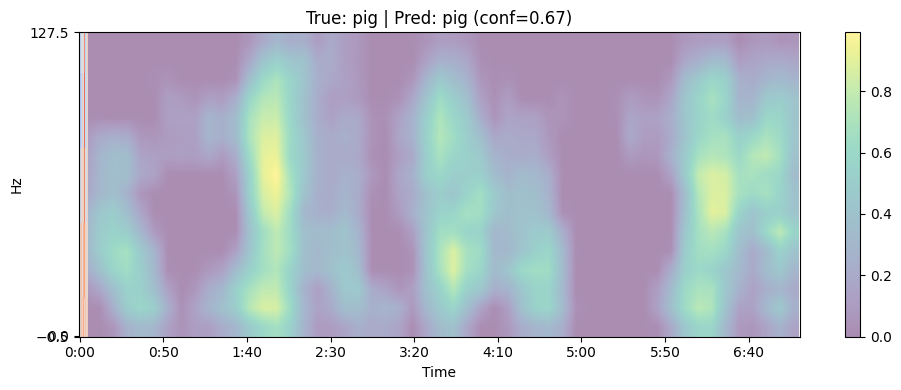

=== Wrong case ===


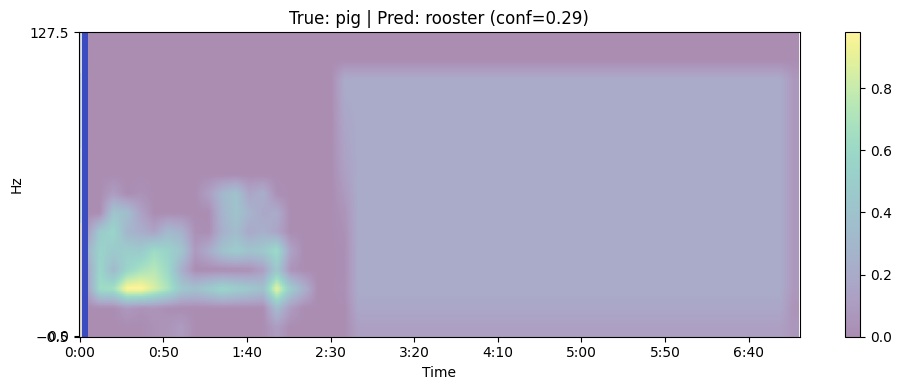

In [ ]:
#Cell 4.4 — Code: Hiển thị 1 case đùng & 1 case sai
# dự đoán toàn test nếu chưa có y_pred
if "y_pred" not in globals():
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
    probs = best_model.predict(test_ds, verbose=0)
    y_pred = np.argmax(probs, axis=1)

# tìm 1 case đùng và 1 case sai
idx_correct = int(np.where(y_pred == y_test)[0][0])
idx_wrong   = int(np.where(y_pred != y_test)[0][0])

def explain_one(idx):
    x = X_test[idx]              # (H,W,1)
    y_true = y_test[idx]
    x_in = x[np.newaxis, ...]    # (1,H,W,1)

    p = best_model.predict(x_in, verbose=0)[0]
    pred_id = int(np.argmax(p))
    conf = float(np.max(p))

    true_name = le.classes_[y_true]
    pred_name = le.classes_[pred_id]

    heatmap = make_gradcam_heatmap(x_in, best_model, last_conv, pred_index=pred_id)

    title = f"True: {true_name} | Pred: {pred_name} (conf={conf:.2f})"
    show_gradcam_on_spec(x[...,0], heatmap, title=title)

print("=== Correct case ===")
explain_one(idx_correct)

print("=== Wrong case ===")
explain_one(idx_wrong)


Confusion rain -> sea_waves: 1 samples


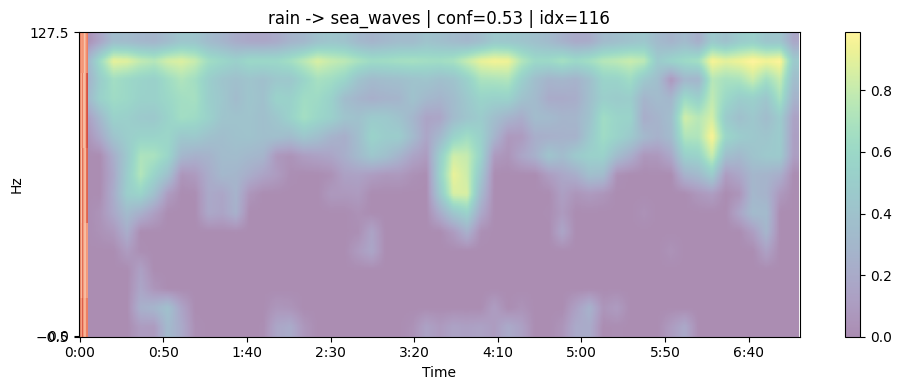

Confusion drinking_sipping -> footsteps: 2 samples


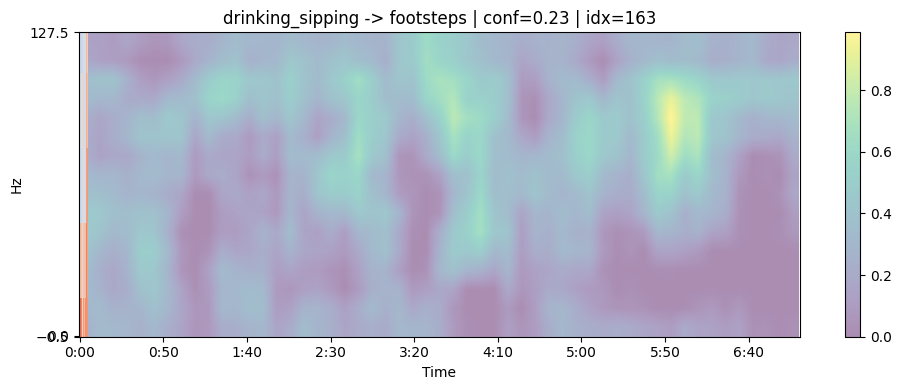

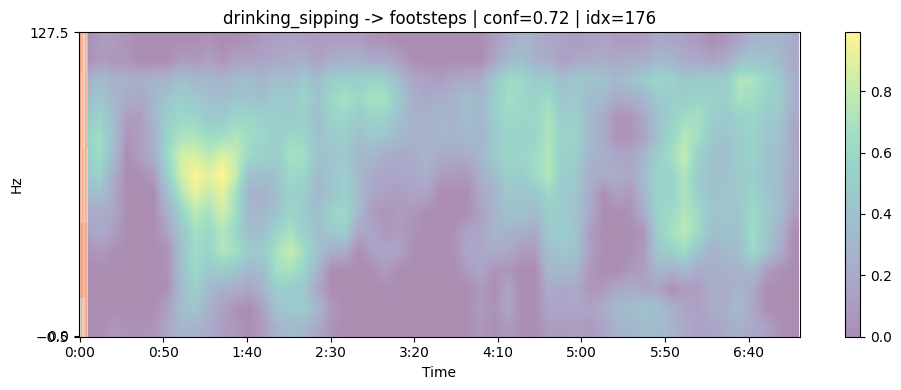

Confusion sheep -> insects: 2 samples


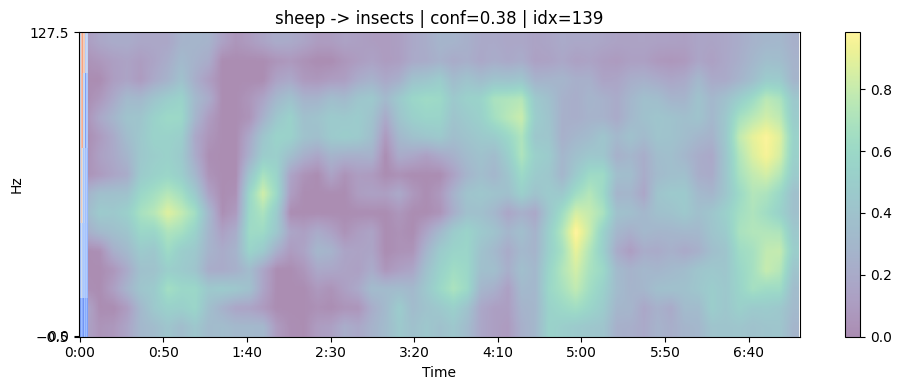

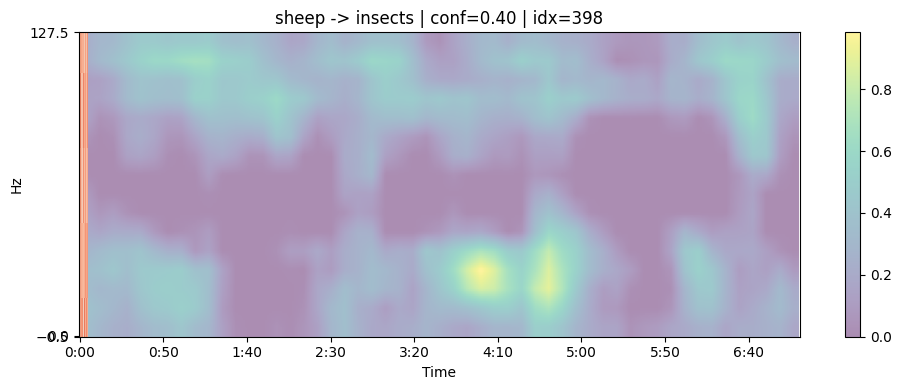

In [ ]:
def explain_confusion(true_label, pred_label, max_show=3):
    true_id = int(np.where(le.classes_ == true_label)[0][0])
    pred_id = int(np.where(le.classes_ == pred_label)[0][0])

    idxs = np.where((y_test == true_id) & (y_pred == pred_id))[0]
    print(f"Confusion {true_label} -> {pred_label}: {len(idxs)} samples")

    for k, idx in enumerate(idxs[:max_show]):
        x = X_test[idx]
        x_in = x[np.newaxis, ...]
        p = best_model.predict(x_in, verbose=0)[0]
        conf = float(np.max(p))

        heatmap = make_gradcam_heatmap(x_in, best_model, last_conv, pred_index=pred_id)
        title = f"{true_label} -> {pred_label} | conf={conf:.2f} | idx={int(idx)}"
        show_gradcam_on_spec(x[...,0], heatmap, title=title)

explain_confusion("rain", "sea_waves", max_show=3)
explain_confusion("drinking_sipping", "footsteps", max_show=3)
explain_confusion("sheep", "insects", max_show=3)


In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Using the first sample from the training set for illustration
idx = 0
label_name = le.inverse_transform([y_train[idx]])[0]

raw = X_train_raw[idx]           # (128, T, 3) - taking the first channel (logmel) for plotting
std = X_train[idx, ..., 0]       # (128, T) - taking the first channel (logmel)

plt.figure(figsize=(10, 5))
librosa.display.specshow(raw[..., 0], x_axis="time", y_axis="mel", hop_length=HOP_LENGTH, sr=SR)
plt.title(f"Raw Log-Mel Spectrogram (dB) | Label: {label_name}")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
librosa.display.specshow(std, x_axis="time", y_axis="mel", hop_length=HOP_LENGTH, sr=SR)
plt.title(f"Standardized Log-Mel Spectrogram | Label: {label_name}")
plt.colorbar()
plt.tight_layout()
plt.show()